<a href="https://colab.research.google.com/github/kjahan/semantic_similarity/blob/main/examples/text_image_embedding_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00


In [2]:
from transformers import AutoFeatureExtractor, AutoModel


model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
!pip3 install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset


dataset = load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset["train"].features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

In [6]:
num_samples = 100
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))


In [7]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [8]:
import torch

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=4)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [10]:
from tqdm import tqdm
import numpy as np

In [11]:
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)


100%|██████████| 100/100 [00:00<00:00, 110.37it/s]


In [12]:
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [13]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels


In [14]:
test_idx = np.random.choice(len(dataset["test"]))
test_sample = dataset["test"][test_idx]["image"]
test_label = dataset["test"][test_idx]["labels"]

sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")


Query label: 1
Top 5 candidate labels: [1, 1, 1, 1, 1]


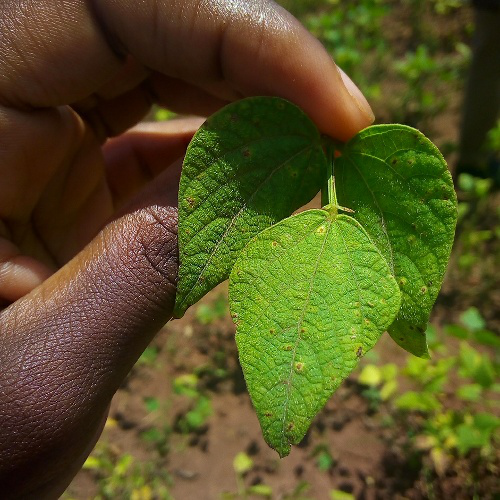

In [15]:
test_sample

In [17]:
type(test_sample)

PIL.JpegImagePlugin.JpegImageFile

## Load images

In [16]:
!mkdir data

## Resize images

In [54]:
import os, sys
from PIL import Image

size = 128, 128

for infile in glob.glob("data/*.png"):
    outfile = os.path.splitext(infile)[0] + ".thumbnail"
    print(outfile)
    if infile != outfile:
        try:
            im = Image.open(infile)
            im.thumbnail(size, resample=Image.LANCZOS)
            im.save(outfile, "PNG")
        except IOError:
            print("cannot create thumbnail for {}".format(infile))

data/prob_4.thumbnail
data/prob_5.thumbnail
data/prob_3.thumbnail
data/prob_2.thumbnail
data/prob_1.thumbnail


data/prob_5.thumbnail


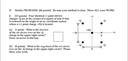

data/prob_2.thumbnail


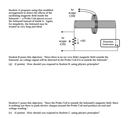

data/prob_4.thumbnail


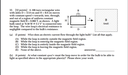

data/prob_1.thumbnail


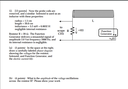

data/prob_3.thumbnail


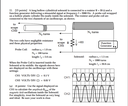

In [55]:
for infile in glob.glob("data/*.thumbnail"):
    print(infile)
    key = infile.replace('data/', '')
    file, ext = os.path.splitext(infile)
    with Image.open(infile) as image:
      # if infile == 'data/prob_1.png':
      image.show()

In [56]:
from PIL import Image
import glob, os

size = 128, 128

img_embeddings = {}

for infile in glob.glob("data/*.thumbnail"):
    print(infile)
    key = infile.replace('data/', '')
    file, ext = os.path.splitext(infile)
    with Image.open(infile).convert('RGB') as image:
      # if infile == 'data/prob_1.png':
      #   image.show()
      # Prepare the input query image for embedding computation.
      image_transformed = transformation_chain(image).unsqueeze(0)
      new_batch = {"pixel_values": image_transformed.to(device)}

      # Comute the embedding.
      with torch.no_grad():
          embeddings_ = model(**new_batch).last_hidden_state[:, 0].cpu()
          img_embeddings[key] = embeddings_

data/prob_5.thumbnail
data/prob_2.thumbnail
data/prob_4.thumbnail
data/prob_1.thumbnail
data/prob_3.thumbnail


In [57]:
img_embeddings.keys()

dict_keys(['prob_5.thumbnail', 'prob_2.thumbnail', 'prob_4.thumbnail', 'prob_1.thumbnail', 'prob_3.thumbnail'])

In [58]:
len(img_embeddings)

5

In [60]:
compute_scores(img_embeddings['prob_1.thumbnail'], img_embeddings['prob_2.thumbnail'])

[0.7686161994934082]

In [61]:
compute_scores(img_embeddings['prob_1.thumbnail'], img_embeddings['prob_3.thumbnail'])

[0.5455225706100464]

In [62]:
compute_scores(img_embeddings['prob_1.thumbnail'], img_embeddings['prob_4.thumbnail'])

[0.8223990201950073]

In [63]:
compute_scores(img_embeddings['prob_1.thumbnail'], img_embeddings['prob_5.thumbnail'])

[0.7774254083633423]